# Deep Learning (Fall 1401 - Dr. Beigy)



# 0. Pre

## Introduction
The purpose of this notebook is to teach you some essentials about the Pytorch library. We will also implement our own dataloader, model, and trainer, so that after we train the model, it can distinguish between different cloths! The good news is, if you do this notebook carefully and appropriately, you will have a nice snippet-base to use later on. So let's start `shift+Enter`ing :)

## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q numpy torch torchvision pillow tqdm

## Imports

In [3]:
from copy import deepcopy
from math import ceil
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import math
import pickle

# 1. Data

## Dataset and Dataloader

### Dataset
We will use Fashion-MNIST dataset for our experiments in this notebook. It is a small dataset, so you will not need a GPU for your training.

In [4]:
# Making datasets
dataset = FashionMNIST(root='fashion-mnist', download=True, train=True)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False)
train_set, val_set = torch.utils.data.random_split(dataset, [55000, 5000])


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-mnist/FashionMNIST/raw



In [5]:
# Testing samples
######################   TODO 1.1   #########################
# Write a function to plot 4 random images from the 
# training set with their respective labels
###################### (5 points) #########################
def show_images(data,labels_map):
  cols, rows = 2, 2
  figure = plt.figure(figsize=(8, 8))
  for i in range(1, cols * rows + 1):
      index = torch.randint(len(data), size=(1,)).item()
      img, label = data[index]
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img, cmap="gray")
  plt.show()

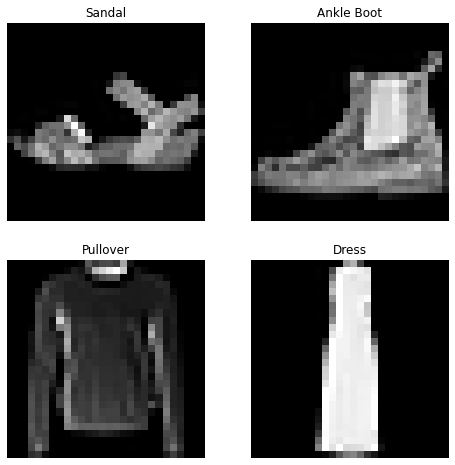

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
  }
show_images(train_set,labels_map)

### Dataloader
Dataloader is an object that combines a dataset and a sampler, and provides an iterable over the given dataset. Pytorch has its own dataloader, but here, to understand what lies under the hood, we will implement our custom one.

In [7]:
class CustomDataloader:
    def __init__(self, dataset, batch_size, shuffle=False, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        # images passed to the dataloader are PIL objests.
        # we need to convert those to tensors:
        self.transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        
    def __len__(self):
        ######################   TODO 1.2   ########################
        # return the count of batches.
        if self.drop_last:
          return len(self.dataset)//self.batch_size
        return ceil(len(self.dataset)/self.batch_size)
        ###################### (1 points) #########################

    def __iter__(self, calm=True):
        indexes = list(range(len(self.dataset)))
        
        if self.shuffle:
          random.shuffle(indexes)
        for idx in range(0, len(self.dataset), self.batch_size):
            ######################   TODO 1.3   ########################
            # construct a batch of images respective to the indexes:
            # 1. construct a list of images
            # 2. convert the list to tensors
            # 3. convert tensors to float32 (each tensor element should be between 0 and 1)
            # 4. construct the respective labels list
            batch_indexes = indexes[idx:idx + self.batch_size]

            #batch_imgs_transformed =[self.transform(self.dataset[i][0]).float() for i in batch_indexes]
            #batch_labels = [self.dataset[i][1] for i in batch_indexes]

            batch_imgs = self.dataset.data[batch_indexes]
            batch_imgs_transformed = batch_imgs.float()
            batch_labels = self.dataset.targets[batch_indexes]
            ###################### (8 points) #########################
            yield batch_imgs_transformed, torch.tensor(batch_labels)
        return


In [8]:
def test_your_dataloader():
    ######################   TODO 1.3   ########################
    # test your dataloader! 
    dataloader = CustomDataloader(train_set.dataset, 32, True, True)
    for data, labels in dataloader:
        print(data.shape)
        print(labels.shape)
        print(labels)
        break
    ###################### (5 points) #########################

test_your_dataloader()

torch.Size([32, 28, 28])
torch.Size([32])
tensor([4, 1, 5, 8, 2, 7, 8, 0, 7, 0, 7, 6, 6, 3, 6, 4, 5, 3, 0, 3, 2, 4, 8, 5,
        0, 8, 0, 9, 6, 8, 1, 2])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

55000
5000
10000


In [10]:
######################   TODO 1.4   #########################
# initialaze the dataloaders, for training_set and test_set
train_dataloader = CustomDataloader(train_set.dataset, 32, False, False)
val_dataloader = CustomDataloader(val_set.dataset, 32, True, False)
test_dataloader = CustomDataloader(test_set, 32, True, False)
###################### (1 points) #########################

# 2. Model
Here, we will implement our network. Our model is a simple feed-forward network that gets an image, flattens the image, then passes it through several linear layers with relu activations.

In [11]:
class Classifier(nn.Module):
    def __init__(self, input_dims, hidden_dims, num_classes):
        super().__init__()
        self.nn_layers = nn.ModuleList([])
        self.activation = nn.ReLU()
        self.flatten = torch.flatten
        ######################   TODO 2.1   ########################
        # construct layers of the network
        # these layers are stored in `self.nn_layers`
        # use `nn.Linear` for all layers
        hidden_dims = hidden_dims
        self.dims = [input_dims[0]*input_dims[1]]
        self.dims.extend(hidden_dims)
        self.dims.append(num_classes)

        # use `self.nn_layers.append`
        for i in range(len(self.dims)-1):
                    ip_dim = self.dims[i]
                    op_dim = self.dims[i+1]
                    self.nn_layers.append(
                        nn.Linear(ip_dim, op_dim)
                    )
        ###################### (10 points) #########################
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x, start_dim=1)
        ######################   TODO 2.2   ########################
        # pass `x` through all the layers of the network.
        # also don't forget the activation functions!
        # don't use `softmax` in the last layer.
        for i, layer in enumerate(self.nn_layers):

            x = layer(x)
            # Do not apply ReLU on the final layer
            if i < (len(self.nn_layers) - 1):
                x = self.activation(x)
        ###################### (5 points) #########################
        return x

    def predict(self, x):
        ######################   TODO 2.3   ########################
        # get the predicted class of x.
        # use softmax and then get the maximum indexes
        x = self.forward(x)
        outputs = self.softmax(x)
        _,prediction = torch.max(outputs, 1)
        ###################### (5 points) #########################
        return prediction


In [12]:
def test_model():
    input_dims = (28,28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    
    cls = Classifier(input_dims, hidden_dims, num_classes)
    x = torch.rand(batch_size, *input_dims)
    assert cls(x).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(x).shape == torch.Size([batch_size])


def test_model_with_dataloader():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    dataloader = CustomDataloader(dataset=test_set, batch_size=batch_size, shuffle=True)
    imgs, labels = next(iter(dataloader))
    cls = Classifier(input_dims, hidden_dims, num_classes)
    assert cls(imgs).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(imgs).shape == torch.Size([batch_size])

test_model()
test_model_with_dataloader()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# 3. Training

## Trainer
Trainer is an object that gets the model, dataloaders, optimizer and criterion and then trains the model with the given data in a training loop. 

In [13]:
class Trainer:
    def __init__(self, 
        train_dataloader, val_dataloader, model,
        optimizer, criterion, *args, **kwargs
    ):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.best_model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_accuracies = []
        self.train_losses = []
        self.val_accuracies = []
        self.val_losses = []
        self.val_loss = None
        self.min_val_loss = np.inf

    def train(self, epochs, log_each_n_percent_epoch):
        self.model.train()
        train_steps = len(self.train_dataloader)
        log_steps = int(train_steps * log_each_n_percent_epoch/100)

        for epoch in range(epochs):
            train_loss = 0.0
            total_train=0.0
            correct_train=0.0
            print(f"epoch {epoch+1} started".title().center(50, "="))

            for step, (data, labels) in tqdm(enumerate(self.train_dataloader)):
                ######################   TODO 3.1   ########################
                # first move the data and labels to gpu if you are using it
                # forward the data, calculate loss and then backpropagate it
                ###################### (10 points) #########################
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()
                self.optimizer.zero_grad()
                target = self.model(data)
                _, predicted_train = torch.max(target.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                loss = self.criterion(target,labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

                # ****** I commented these lines cause I wanted to print info in every epoch not iterations!
                # if step % log_steps == 1:
                #     self.val_loss, accuracy = self.evaluate(save=True,checkpoint_path='/content/drive/MyDrive/MSC1401_1/DeepLearning/HW1/Practical/checkpoints')
                #     info_text = f'Validation Loss: {self.val_loss:.6f}\tValidation Accuracy: {accuracy:.2f}'
                #     print(info_text)
                #     self.post_evaluation_actions()
            
            self.val_loss, accuracy = self.evaluate(save=True,checkpoint_path='/content/drive/MyDrive/MSC1401_1/DeepLearning/HW1/Practical/checkpoints/')
            acc = 100*correct_train/total_train
            lss = train_loss / len(self.train_dataloader)
            self.train_accuracies.append(acc)
            self.train_losses.append(lss)

            info_text = f'Validation Loss: {self.val_loss:.6f}\tValidation Accuracy: {accuracy:.2f}'
            print(info_text)
            info_text = f'Train Loss: {lss:.6f}\tTrain Accuracy: {acc:.2f}'
            print(info_text)  

    def evaluate(self, save=False,checkpoint_path=''):
        valid_loss = 0.0
        total_val = 0.0
        correct_val = 0.0
        self.model.eval()
        with torch.no_grad():
            ######################   TODO 3.2   ########################
            # run the prediction on the validation dataloader,
            # calculate loss and accuracy
            for data, labels in self.val_dataloader:
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()
                torch.cuda.empty_cache()
                target = self.model(data)
                _, predicted_val = torch.max(target.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
                loss = self.criterion(target,labels)
                valid_loss += loss.item()

            ###################### (5 points) #########################
            accuracy = 100*correct_val/total_val
            self.val_loss = valid_loss / len(self.val_dataloader)

            self.val_losses.append(self.val_loss)
            self.val_accuracies.append(accuracy)
            
            if save:

              with open('{}{}_train_losses.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.train_losses, f)
              with open('{}{}_valid_losses.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.val_losses, f)
              with open('{}{}_train_accuracies.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.train_accuracies, f)
              with open('{}{}_valid_accuracies.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.val_accuracies, f)
              if loss < self.min_val_loss:
                  torch.save(self.model.state_dict(),'{}{}_best_model.pth'.format(checkpoint_path,self.optimizer.__class__.__name__))
                  self. min_val_loss = loss
                  self.best_model = self.model
            valid_loss = self.val_loss

            return valid_loss, accuracy

    def post_evaluation_actions(self):
      pass

## Train

In [19]:
######################   TODO 3.3   #########################
# complete empty variables 
# init your model, then put it on GPU if available,
# use `SGD` as your optimizer,
# set the appropriate `learning_rate`
# use `nn.CrossEntropyLoss()` as criterion.
input_dims = (28,28)
hidden_dims = [1000,1500,300]
num_classes = 10

model = Classifier(input_dims, hidden_dims, num_classes)

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
###################### (5 points) #########################

In [20]:
######################   TODO 3.4   #######################
# init trainer and then train it as much as you want.
# accuracy scores less than 86% won't recieve any points.
trainer = Trainer(train_dataloader, val_dataloader, model,
        optimizer, criterion)
trainer.train(20, 100)
###################### (5 points) #########################

=================Epoch 1 Started==================


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation Loss: 0.388750	Validation Accuracy: 86.11
Train Loss: 0.502913	Train Accuracy: 82.74
=================Epoch 2 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.325996	Validation Accuracy: 88.22
Train Loss: 0.353621	Train Accuracy: 87.38
=================Epoch 3 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.298888	Validation Accuracy: 89.07
Train Loss: 0.309764	Train Accuracy: 88.76
=================Epoch 4 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.274342	Validation Accuracy: 89.92
Train Loss: 0.277394	Train Accuracy: 89.99
=================Epoch 5 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.261414	Validation Accuracy: 90.39
Train Loss: 0.251738	Train Accuracy: 91.00
=================Epoch 6 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.246776	Validation Accuracy: 90.97
Train Loss: 0.230118	Train Accuracy: 91.82
=================Epoch 7 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.237166	Validation Accuracy: 91.29
Train Loss: 0.210254	Train Accuracy: 92.61
=================Epoch 8 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.225636	Validation Accuracy: 91.72
Train Loss: 0.192520	Train Accuracy: 93.34
=================Epoch 9 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.212361	Validation Accuracy: 92.27
Train Loss: 0.175861	Train Accuracy: 93.98
=================Epoch 10 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.209416	Validation Accuracy: 92.40
Train Loss: 0.160445	Train Accuracy: 94.57
=================Epoch 11 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.200901	Validation Accuracy: 92.76
Train Loss: 0.146398	Train Accuracy: 95.13
=================Epoch 12 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.197017	Validation Accuracy: 92.89
Train Loss: 0.133791	Train Accuracy: 95.59
=================Epoch 13 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.190960	Validation Accuracy: 93.13
Train Loss: 0.121703	Train Accuracy: 96.10
=================Epoch 14 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.190668	Validation Accuracy: 93.16
Train Loss: 0.109784	Train Accuracy: 96.54
=================Epoch 15 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.199777	Validation Accuracy: 92.94
Train Loss: 0.100354	Train Accuracy: 96.90
=================Epoch 16 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.196032	Validation Accuracy: 93.06
Train Loss: 0.091553	Train Accuracy: 97.22
=================Epoch 17 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.201387	Validation Accuracy: 93.05
Train Loss: 0.083475	Train Accuracy: 97.55
=================Epoch 18 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.219060	Validation Accuracy: 92.64
Train Loss: 0.075777	Train Accuracy: 97.81
=================Epoch 19 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.195092	Validation Accuracy: 93.32
Train Loss: 0.069962	Train Accuracy: 98.06
=================Epoch 20 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.213284	Validation Accuracy: 92.86
Train Loss: 0.063962	Train Accuracy: 98.24


In [22]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data,labels in test_dataloader:
        if torch.cuda.is_available():
            images, labels = data.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network trained with SGD on the test images: %d %%' % (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network trained with SGD on the test images: 86 %


In [23]:
######################   TODO 3.5   #######################
# repeat the training with another optimizer.
input_dims = (28,28)
hidden_dims = [1000,1500,300]
num_classes = 10

model = Classifier(input_dims, hidden_dims, num_classes)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

trainer = Trainer(train_dataloader, val_dataloader, model,
        optimizer, criterion)
trainer.train(20, 100)
###################### (5 points) #########################

=================Epoch 1 Started==================


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation Loss: 0.340027	Validation Accuracy: 87.25
Train Loss: 0.482374	Train Accuracy: 83.51
=================Epoch 2 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.295436	Validation Accuracy: 88.66
Train Loss: 0.338284	Train Accuracy: 87.50
=================Epoch 3 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.264286	Validation Accuracy: 89.98
Train Loss: 0.294308	Train Accuracy: 89.14
=================Epoch 4 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.250438	Validation Accuracy: 90.51
Train Loss: 0.265160	Train Accuracy: 89.98
=================Epoch 5 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.247119	Validation Accuracy: 90.43
Train Loss: 0.237186	Train Accuracy: 91.05
=================Epoch 6 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.230376	Validation Accuracy: 91.10
Train Loss: 0.218626	Train Accuracy: 91.64
=================Epoch 7 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.226985	Validation Accuracy: 91.30
Train Loss: 0.199405	Train Accuracy: 92.49
=================Epoch 8 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.244884	Validation Accuracy: 90.74
Train Loss: 0.185876	Train Accuracy: 92.94
=================Epoch 9 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.253008	Validation Accuracy: 90.54
Train Loss: 0.170500	Train Accuracy: 93.51
=================Epoch 10 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.238938	Validation Accuracy: 91.23
Train Loss: 0.160990	Train Accuracy: 93.89
=================Epoch 11 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.240915	Validation Accuracy: 91.29
Train Loss: 0.149079	Train Accuracy: 94.31
=================Epoch 12 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.226862	Validation Accuracy: 91.71
Train Loss: 0.141571	Train Accuracy: 94.58
=================Epoch 13 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.215237	Validation Accuracy: 92.02
Train Loss: 0.132547	Train Accuracy: 94.89
=================Epoch 14 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.225276	Validation Accuracy: 92.12
Train Loss: 0.127598	Train Accuracy: 95.15
=================Epoch 15 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.216874	Validation Accuracy: 92.42
Train Loss: 0.118443	Train Accuracy: 95.51
=================Epoch 16 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.206519	Validation Accuracy: 92.84
Train Loss: 0.112200	Train Accuracy: 95.73
=================Epoch 17 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.183236	Validation Accuracy: 93.53
Train Loss: 0.108115	Train Accuracy: 95.89
=================Epoch 18 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.193841	Validation Accuracy: 93.34
Train Loss: 0.108940	Train Accuracy: 95.99
=================Epoch 19 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.204857	Validation Accuracy: 93.06
Train Loss: 0.095183	Train Accuracy: 96.39
=================Epoch 20 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.193694	Validation Accuracy: 93.28
Train Loss: 0.094838	Train Accuracy: 96.45


In [51]:
correct = 0
total = 0
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data,labels in test_dataloader:
        if torch.cuda.is_available():
            images, labels = data.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    y_true = np.concatenate( y_true, axis=0 )
    y_pred = np.concatenate( y_pred, axis=0 )

print('Accuracy of the network trained with ADAM on the test images: %d %%' % (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network trained with ADAM on the test images: 88 %


## Trainer with Early Stopping
First, feel free to study about Early Stopping technique on the internet. Then come along to the next cell.

Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops. 

In [69]:
class EarlyStppedException(Exception):
      def  __init__(self):
        super().__init__()
        pass



class TrainerWithEarlyStopping(Trainer):
    def  __init__(self, train_dataloader, val_dataloader, model,
        optimizer, criterion, n_epoch_stop, *args, **kwargs):
        ######################   TODO 3.6   #######################
        # Here, save any arguments you need from kwargs into `self`
        ###################### (3 points) #########################
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.best_model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_accuracies = []
        self.train_losses = []
        self.val_accuracies = []
        self.val_losses = []
        self.val_loss = None
        self.min_val_loss = np.inf
        self.epoch_no_improve = 0
        self.n_epoch_stop = 0
        self.early_stop = False

    def train(self, epochs, log_each_n_percent_epoch):
        self.model.train()
        train_steps = len(self.train_dataloader)
        log_steps = int(train_steps * log_each_n_percent_epoch/100)

        for epoch in range(epochs):
            train_loss = 0.0
            total_train=0.0
            correct_train=0.0
            print(f"epoch {epoch+1} started".title().center(50, "="))

            for step, (data, labels) in tqdm(enumerate(self.train_dataloader)):
                
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()
                self.optimizer.zero_grad()
                target = self.model(data)
                _, predicted_train = torch.max(target.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                loss = self.criterion(target,labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            
            path='/content/drive/MyDrive/MSC1401_1/DeepLearning/HW1/Practical/checkpoints/'
            self.val_loss, accuracy = self.evaluate(save=True,checkpoint_path=path)
            try:
                if epoch > 5 and self.epoch_no_improve == self.n_epoch_stop:
                    self.early_stop = True
                    raise EarlyStppedException()
            except:
                print("Early Stopped Training at epoch"+ str(epoch))
                torch.save(self.model.state_dict(),'{}{}_best_model.pth'.format(path,self.optimizer.__class__.__name__))
                break

            acc = 100*correct_train/total_train
            lss = train_loss / len(self.train_dataloader)
            self.train_accuracies.append(acc)
            self.train_losses.append(lss)

            info_text = f'Validation Loss: {self.val_loss:.6f}\tValidation Accuracy: {accuracy:.2f}'
            print(info_text)
            info_text = f'Train Loss: {lss:.6f}\tTrain Accuracy: {acc:.2f}'
            print(info_text)  

    def evaluate(self, save=False,checkpoint_path=''):
        valid_loss = 0.0
        total_val = 0.0
        correct_val = 0.0
        self.model.eval()
        with torch.no_grad():
            for data, labels in self.val_dataloader:
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()
                torch.cuda.empty_cache()
                target = self.model(data)
                _, predicted_val = torch.max(target.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
                loss = self.criterion(target,labels)
                valid_loss += loss.item()

            ###################### (5 points) #########################
            accuracy = 100*correct_val/total_val
            self.val_loss = valid_loss / len(self.val_dataloader)

            self.val_losses.append(self.val_loss)
            self.val_accuracies.append(accuracy)
            
            if save:

              with open('{}{}_train_losses.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.train_losses, f)
              with open('{}{}_valid_losses.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.val_losses, f)
              with open('{}{}_train_accuracies.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.train_accuracies, f)
              with open('{}{}_valid_accuracies.pickle'.format(checkpoint_path,self.optimizer.__class__.__name__),'wb') as f:
                  pickle.dump(self.val_accuracies, f)
              if loss < self.min_val_loss:
                  torch.save(self.model.state_dict(),'{}{}_best_model.pth'.format(checkpoint_path,self.optimizer.__class__.__name__))
                  self. min_val_loss = loss
                  self.best_model = self.model
                  self.epoch_no_improve = 0
              else:
                  self.epoch_no_improve += 1


            valid_loss = self.val_loss

            return valid_loss, accuracy



    def post_evaluation_actions(self):
        ######################   TODO 3.6   #######################
        # In this method, you should first save the best model each
        # time the loss decreases. Don't forget to use `deepcopy`!
        # Then use your defined arguments to check for early stopp-
        # ing. In case of eary stopping raise `EarlyStppedException`
        # exception.
        pass #************** the early stopping check is implemented in evaluate method above
        ###################### (7 points) #########################

In [70]:
######################   TODO 3.6   #######################
# Train a new model using our new trainer.
# to claim the earlystopping point you should also do this
# section.
###################### ( 0 points) #########################

input_dims = (28,28)
hidden_dims = [1000,1500,300]
num_classes = 10

model = Classifier(input_dims, hidden_dims, num_classes)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

trainer = TrainerWithEarlyStopping(train_dataloader, val_dataloader, model,
        optimizer, criterion,2) #### to test the early stopping method I chose to raise exception if after 2 epochs validation loss does not decreas.
trainer.train(20, 100)

=================Epoch 1 Started==================


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation Loss: 0.402001	Validation Accuracy: 85.49
Train Loss: 0.611650	Train Accuracy: 80.86
=================Epoch 2 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.377179	Validation Accuracy: 86.15
Train Loss: 0.431518	Train Accuracy: 84.73
=================Epoch 3 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.357911	Validation Accuracy: 87.48
Train Loss: 0.398298	Train Accuracy: 86.03
=================Epoch 4 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.331468	Validation Accuracy: 87.69
Train Loss: 0.373071	Train Accuracy: 86.78
=================Epoch 5 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.323126	Validation Accuracy: 88.41
Train Loss: 0.361717	Train Accuracy: 87.13
=================Epoch 6 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.314327	Validation Accuracy: 88.35
Train Loss: 0.347521	Train Accuracy: 87.62
=================Epoch 7 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.317518	Validation Accuracy: 88.28
Train Loss: 0.333751	Train Accuracy: 87.95
=================Epoch 8 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.317862	Validation Accuracy: 88.47
Train Loss: 0.329595	Train Accuracy: 88.15
=================Epoch 9 Started==================


0it [00:00, ?it/s]

Early Stopped Training at epoch8


# 4. Plots

**4.1. plot the learning curves for both optimizers.(5 points)**

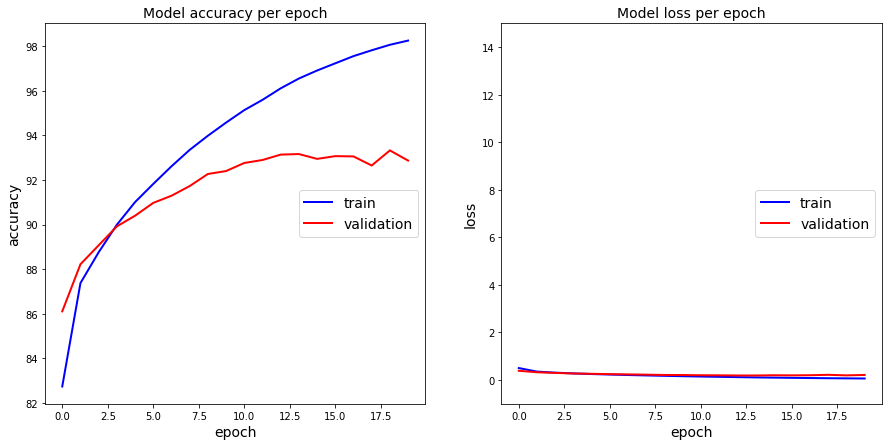

In [21]:
#SGD
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(trainer.train_accuracies,"blue",linewidth=2)
plt.plot(trainer.val_accuracies,"red",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=14)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'validation'], loc='right',fontsize=14)

#Loss curves
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(trainer.train_losses,"blue",linewidth=2)
plt.plot(trainer.val_losses,"red",linewidth=2)
plt.title('Model loss per epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.ylim(-1,15)
plt.legend(['train', 'validation'], loc='right',fontsize=14)
plt.show()

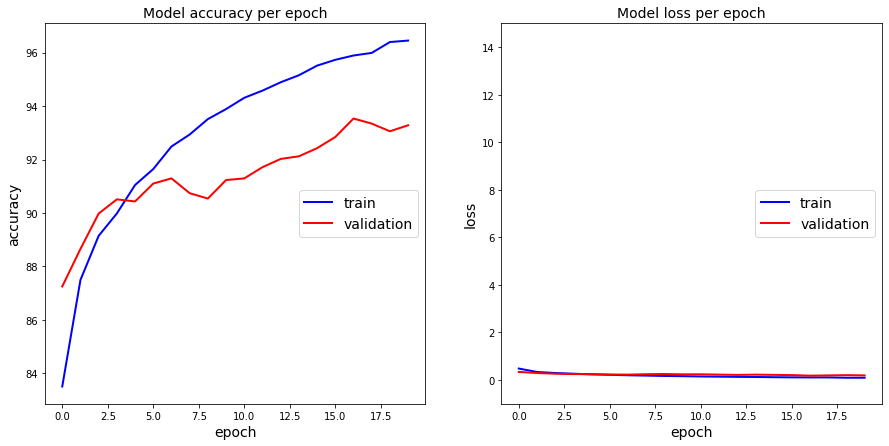

In [26]:
#ADAM

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(trainer.train_accuracies,"blue",linewidth=2)
plt.plot(trainer.val_accuracies,"red",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=14)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'validation'], loc='right',fontsize=14)

#Loss curves
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(trainer.train_losses,"blue",linewidth=2)
plt.plot(trainer.val_losses,"red",linewidth=2)
plt.title('Model loss per epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.ylim(-1,15)
plt.legend(['train', 'validation'], loc='right',fontsize=14)
plt.show()

**4.2. plot the confusion matrix on the test set (5 points)**

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.72      0.78      1000
           3       0.89      0.89      0.89      1000
           4       0.76      0.83      0.79      1000
           5       0.99      0.96      0.97      1000
           6       0.71      0.63      0.67      1000
           7       0.95      0.95      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



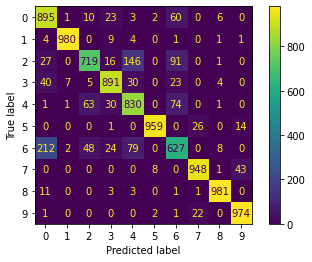

In [54]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
cm=confusion_matrix(y_true,y_pred)
print(classification_report(y_true ,y_pred ))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 5. Conclusion

**5.1. what does `torch.no_grad()` do? (5 points)**

With torch.no_grad() method is like a loop in which every tensor in that loop will have a requires_grad set to False. It means that the tensors with gradients currently attached to the current computational graph are now detached from the current graph and no longer we will be able to compute the gradients with respect to that tensor. Until the tensor is within the loop it is detached from the current graph. As soon as the tensor defined with gradient is out of the loop, it is again attached to the current graph. This method disables the gradient calculation which reduces the memory consumption for computations.

**5.2. what is the diference between `CrossEntropyLoss` and `NLLLOSS`? Could we use `NLLLOSS` instead? How? (5 points)**

In short, when using the newer and simpler approach for multi-class classification(CEloss), you don’t apply any activation to the output and then CrossEntropyLoss applies log-SoftMax internally. When using the older approach for multi-class classification(NLLLoss), you apply LogSoftmax to the output and NLLLoss assumes you’ve done so.
When making a prediction, with the CrossEntropyLoss technique the raw output values will be logits so if you want to view probabilities you must apply SoftMax. With the older NLLLoss technique, the raw output values will be log of SoftMax so if you want to view probabilities you must apply the exp() function.
To summarize, when designing a neural network multi-class classifier, you can you CrossEntropyLoss with no activation, or you can use NLLLoss with log-SoftMax activation. This applies only to multi-class classification